In [11]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

# my modules
from ReadFile import Read
from CenterofMass import CenterOfMass

In [12]:
# Gravitational Constant
# converting G to units of kpc*km^2/s^2/Msun
G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # 4.498768e-6*u.kpc**3/u.Gyr**2/u.Msun

In [17]:
class MassProfile:
    # Class to define the Mass and Rotation Curve of a Galaxy
    
    def __init__(self, galaxy, snap):
    # Initialize the instance of this Class with the following properties:
    # galaxy :  string, e.g. "MW"
    #  snap :  integer, e.g  1
    
        # Determine Filename
        # add a string of the filenumber to the value "000"
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        # create filenames
        self.filename='%s_'%(galaxy) + ilbl + '.txt'
        
        # read in the file                                                                                             
        self.time, self.total, self.data = Read(self.filename)

        # store the mass, positions, velocities of all particles                                
        self.m = self.data['m']#*u.Msun
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
    
        # store galaxy name
        self.gname = galaxy
    
    
    
    def MassEnclosed(self, ptype, R):
    # Function that determines the MassEnclosed of particles of a given type
    # input: ptype  Particle type,  1=Halo, 2=Disk, 3=Bulge
    #        R   A One Dimensional Array of Radii within which to compute the mass enclosed. 
    # return: an array with the Mass enclosed (units of Msun)
        
        # Determine the COM position using Disk Particles
        # Disk Particles afford the best centroiding.
        # Create a COM object
        COM = CenterOfMass(self.filename,2)
        # Store the COM position of the galaxy
        # Set Delta = whatever you determined to be a good value in Homework 4.
        GalCOMP = COM.COM_P(0.1)
            
        # create an array to store indexes of particles of desired Ptype                                                
        index = np.where(self.data['type'] == ptype)

        # Store positions of particles of given ptype from the COMP. 
        xG = self.x[index] - GalCOMP[0]
        yG = self.y[index] - GalCOMP[1]
        zG = self.z[index] - GalCOMP[2]
            
        # Compute the mag. of the 3D radius
        rG = np.sqrt(xG**2 + yG**2 + zG**2)
            
        # store mass of particles of a given ptype
        mG = self.m[index]
            
        # Array to store enclosed mass as a function of the input radius array
        Menc = np.zeros(np.size(R))
    
        # set up a while loop that continues until the end of the input radius array
        for i in range(np.size(R)):
            # Only want particles within the given radius
            indexR = np.where(rG <  R[i]*u.kpc)
            Menc[i] = np.sum(mG[indexR])*1e10         
        
        # return the array of enclosed mass with appropriate units
        return Menc*u.Msun
        
    
    def MassEnclosedTotal(self, R):
    # Determine the total mass of each galaxy 
        # Input:   R   Radius 
        # Returns: Mass in units Msun. 
            
        # Sum up all the mass of each component.
        Menc = self.MassEnclosed(1,R) + self.MassEnclosed(2,R) + self.MassEnclosed(3,R)
    
        # Recall that M33 only has 2 components!  No bulge
        if (self.gname == 'M33'):
            Menc = self.MassEnclosed(1,R) + self.MassEnclosed(2,R)  
          
        return Menc
    
        
        
    def HernquistMass(self, R, scale, Mhalo):
    # Determine the mass enclosed using Hernquist 1990 Mass profile 
    # Input:   R   Radius  
    #         scale   Scale Length  
    #         Mhalo  Total Halo Mass (Msun)
    # Returns: Mass in units Msun. 
    
        # Hernquist 1990 Mass profile
        return Mhalo*R**2/(R+scale)**2*u.Msun
       
        
        
        
    def CircularVelocity(self, ptype, R):
    # Function that determines the circular speed at a given radius using the mass enclosed
    # Input:  ptype  Particle type
    #         R    ARRAY of Radii 
    # Returns:  An ARRAY of Circular speeds in units of km/s
    # NOTE: this method assumes spherical symmetry - but the disk is not spherically symmetric.
    
        # call MassEnclosed to determine array of masses within R.
        Menc = self.MassEnclosed(ptype,R)
        
        # Determine the circular speed as a function of input radius assuming spherical symmetry 
        # note that rad needs units 
        # This will return units of kpc/Gyr
        Vcirc = np.round(np.sqrt(G*Menc/R/u.kpc),2)
        
        # Return array Vcirc
        return  Vcirc 
    
    
    def CircularVelocityTotal(self, R):
    # Function that determines the combined circular speed, using all galactic components
    # Input:  R Array of Radii
    # Returns: An Array of Circular speends in units of km/s
    
        # compute the total mass enclosed
        Menc = self.MassEnclosedTotal(R)
        
        # Determine the circular speed as a function of input radius assuming spherical symmetry 
        # note that rad needs units 
        # This will return units of kpc/Gyr
        Vcirc = np.round(np.sqrt(G*Menc/R/u.kpc),2)
        
        # Return array Vcirc
        return  Vcirc 
    
    
    
    def HernquistVCirc(self, R, scale, Mhalo):
    # Function that determines the theoretical circular speed of a Hernquist 1990 Halo
    # input:  R  radius
    #        scale  Scale Length  
    #         Mhalo  Total Halo Mass (Msun)
    # Returns: Vircular Velocity in units km/s.        
             
        # Store the enclosed mass 
        Menc = self.HernquistMass(R,scale,Mhalo)
    
        # Circular speed using enclosed mass
        # rounded to 2 decimal places 
        # You could also write this analytically without first calling HernquistMass
        Vcirc = np.round(np.sqrt(G*Menc/R/u.kpc),2)
        
        # Returns array Vcirc 
        return Vcirc 
    
    
        
        

In [18]:
# Create MassProfile Objects for each Galaxy

MW = MassProfile("MW",0)
M31 = MassProfile("M31",0)
M33 = MassProfile("M33",0)

In [19]:
# TESTING
###############

# test Radius
RR = 30

# array of radii, not starting at 0.
# intervales of 1 kpc
testR = np.arange(0.1,RR+1,1.0)

In [20]:
# Testing Code and Hernquist Halo Match
# MW at 30 kpc
######################################

# scale radius to test
ScaleMW = 61
# total Halo Mass from M31
MtotMW = 1.975e12 

# Mass enclosed from simulation
MtestMW = MW.MassEnclosed(1,testR)

#Mass enclosed from Hernquist Profile  
HtestMW = np.round(MW.HernquistMass(RR,ScaleMW,MtotMW)/1e10,2)


# Circular Velocity using mass enclosed from simulation
VtestMW = MW.CircularVelocity(1,testR)

# Circular Velocity from hernquist profile
HVtestMW = MW.HernquistVCirc(RR,ScaleMW,MtotMW)

print("Testing MW at 30 kpc")
print("********************")
print("Scale Radius", ScaleMW)
print(np.round(MtestMW[RR]/1e10),"x 1e10")
print("Hernquist", HtestMW, "x 1e10")
print(" ")
print(VtestMW[RR])
print("Hernquist Vc",HVtestMW)

Testing MW at 30 kpc
********************
Scale Radius 61
21.0 solMass x 1e10
Hernquist 21.46 solMass x 1e10
 
173.78 km / s
Hernquist Vc 175.42 km / s


In [21]:
# Testing Code and Hernquist Halo Match
# M31 at 30 kpc
########################################

# scale radius to test
ScaleM31 = 62
# total Halo Mass of M31 from Assignment 3
MtotM31 = 1.921e12 


# Mass enclosed from simulation
MtestM31 = M31.MassEnclosed(1,testR)

#Mass enclosed from Hernquist Profile  
HtestM31 = np.round(M31.HernquistMass(RR,ScaleM31, MtotM31)/1e10,2)


# Circular Velocity using mass enclosed from simulation
VtestM31 = M31.CircularVelocity(1,testR)

# Circular Velocity from hernquist profile
HVtestM31 = M31.HernquistVCirc(RR,ScaleM31, MtotM31)


print("Testing M31 at 30 kpc")
print("********************")
print("Scale Radius", ScaleM31)
print(np.round(MtestM31[RR]/1e10),"x 1e10")
print("Hernquist", HtestM31, "x 1e10")
print(" ")
print(VtestM31[RR])
print("Hernquist Vc",HVtestM31)

Testing M31 at 30 kpc
********************
Scale Radius 62
21.0 solMass x 1e10
Hernquist 20.43 solMass x 1e10
 
171.39 km / s
Hernquist Vc 171.13 km / s


In [22]:
# Testing Code and Hernquist Halo Match
# M33 at 30 kpc
########################################

# scale radius to test
ScaleM33 = 25
# total Halo Mass of M33 from Assignment 3
MtotM33 = 0.187e12 


# Mass enclosed from simulation
MtestM33 = M33.MassEnclosed(1,testR)

#Mass enclosed from Hernquist Profile  
HtestM33 = np.round(M33.HernquistMass(RR,ScaleM33, MtotM33)/1e10,2)

# Circular Velocity using mass enclosed from simulation
VtestM33 = M33.CircularVelocity(1,testR)

# Circular Velocity from hernquist profile
HVtestM33 = M33.HernquistVCirc(RR,ScaleM33, MtotM33)

print("Testing M33 at 30 kpc")
print("********************")
print("Scale Radius", ScaleM33)
print(np.round(MtestM33[RR]/1e10),"x 1e10")
print("Hernquist", HtestM33, "x 1e10")
print(" ")
print(VtestM33[RR])
print("Hernquist Vc",HVtestM33)

Testing M33 at 30 kpc
********************
Scale Radius 25
6.0 solMass x 1e10
Hernquist 5.56 solMass x 1e10
 
89.53 km / s
Hernquist Vc 89.31 km / s


In [23]:
# Create an array to store Radius, from 0-30 kpc
# intervals of 0.5 kpc
# don't start at 0.
R = np.arange(0.1,31,0.5)

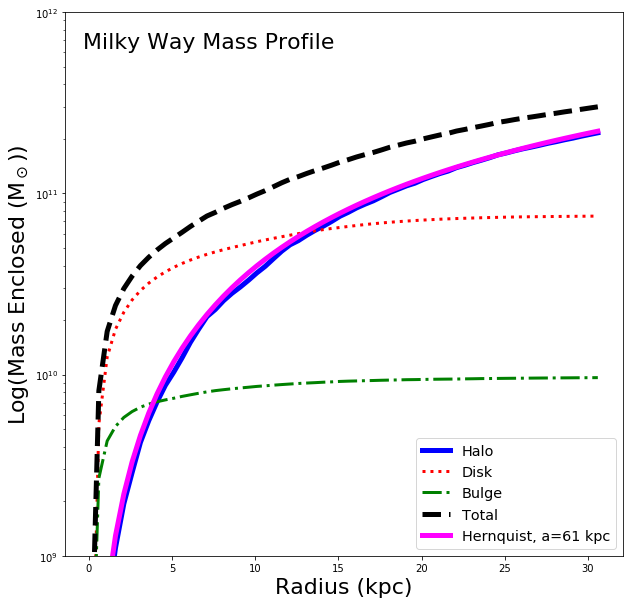

In [24]:
# Plot the Mass Profile for the MW.
####################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot mass enclosed for Halo 
plt.semilogy(R,MW.MassEnclosed(1,R), color='blue', linewidth=5, label='Halo')

# for Disk
plt.semilogy(R,MW.MassEnclosed(2,R), color='red', linestyle=":", linewidth=3, label='Disk')

# for bulge
plt.semilogy(R,MW.MassEnclosed(3,R), color='green', linestyle="-.",linewidth=3, label='Bulge')

# TOTAL Mass
plt.semilogy(R,MW.MassEnclosedTotal(R), color='black', linestyle="--",linewidth=5, label='Total')

# Hernquist Profile
plt.semilogy(R,MW.HernquistMass(R,ScaleMW,MtotMW), color='magenta',linewidth=5, label='Hernquist, a=61 kpc')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel(r'Log(Mass Enclosed (M$_\odot$))', fontsize=22)

#set axis limits
plt.ylim(1e9,1e12)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
# do it this way!!: 
#plt.rcParams.update[{'font.size':20}]


# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'Milky Way Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('MassProfile_MW.eps', rasterized=True, dpi=350)

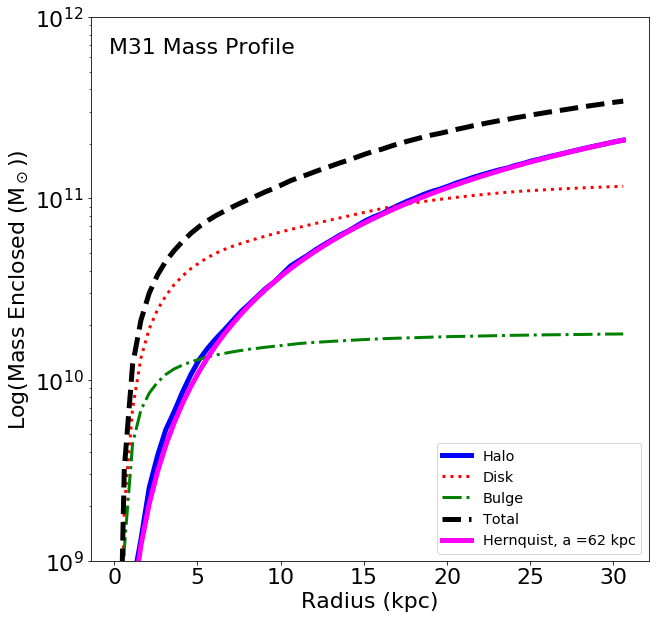

In [25]:
# Plot the Mass Profile for M31.
####################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


# Plot mass enclosed for Halo 
plt.semilogy(R,M31.MassEnclosed(1,R), color='blue', linewidth=5, label='Halo')

# for Disk
plt.semilogy(R,M31.MassEnclosed(2,R), color='red', linestyle=":", linewidth=3, label='Disk')

# for bulge
plt.semilogy(R,M31.MassEnclosed(3,R), color='green', linestyle="-.",linewidth=3, label='Bulge')

# TOTAL Mass
plt.semilogy(R,M31.MassEnclosedTotal(R), color='black', linestyle="--",linewidth=5, label='Total')

# Hernquist Profile
plt.semilogy(R,M31.HernquistMass(R,ScaleM31,MtotM31), color='magenta',linewidth=5, label='Hernquist, a =62 kpc')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel(r'Log(Mass Enclosed (M$_\odot$))', fontsize=22)

#set axis limits
plt.ylim(1e9,1e12)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'M31 Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('MassProfile_M31.eps', rasterized=True, dpi=350)

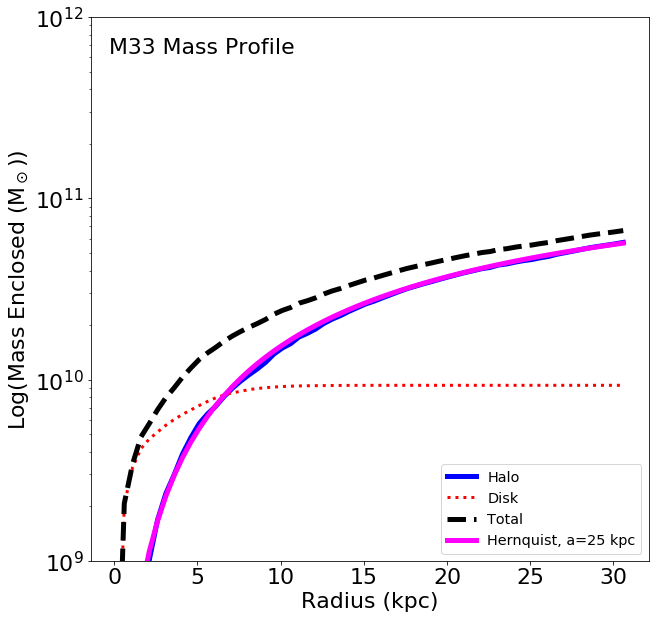

In [26]:
# Plot the Mass Profile for M33.
####################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


# Plot mass enclosed for Halo 
plt.semilogy(R,M33.MassEnclosed(1,R), color='blue', linewidth=5, label='Halo')

# for Disk
plt.semilogy(R,M33.MassEnclosed(2,R), color='red', linestyle=":", linewidth=3, label='Disk')

# TOTAL Mass
plt.semilogy(R,M33.MassEnclosedTotal(R), color='black', linestyle="--",linewidth=5, label='Total')

# Hernquist Profile
plt.semilogy(R,M33.HernquistMass(R,ScaleM33,MtotM33), color='magenta',linewidth=5, label='Hernquist, a=25 kpc')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel(r'Log(Mass Enclosed (M$_\odot$))', fontsize=22)

#set axis limits
plt.ylim(1e9,1e12)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'M33 Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('MassProfile_M33.eps', rasterized=True, dpi=350)

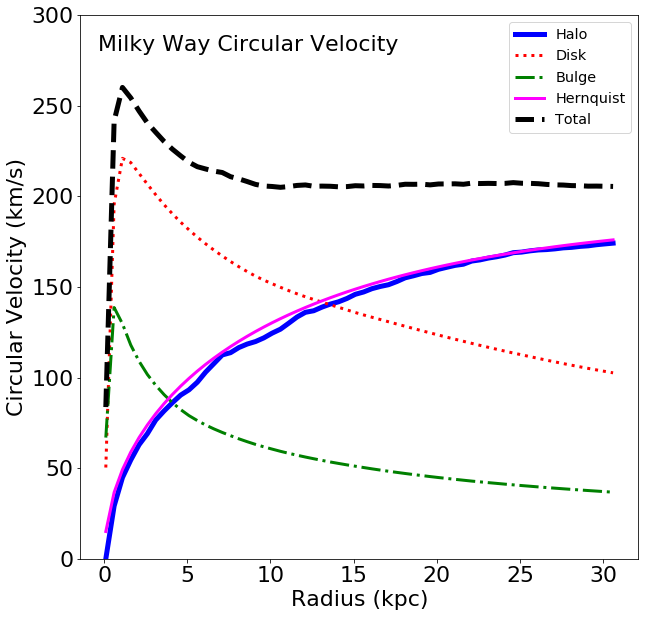

In [27]:
# Plot the Circular Velocity Profile for the MW.
#############################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


# Plot circular velocity for Halo 
plt.plot(R,MW.CircularVelocity(1,R), color='blue', linewidth=5, label='Halo')

# for Disk
plt.plot(R,MW.CircularVelocity(2,R), color='red', linestyle=":", linewidth=3, label='Disk')

# for Bulge
plt.plot(R,MW.CircularVelocity(3,R), color='green', linestyle="-.",linewidth=3, label='Bulge')

# Hernquist Vcirc Profile
plt.plot(R,MW.HernquistVCirc(R,ScaleMW,MtotMW), color='magenta',linewidth=3, label='Hernquist')

# TOTAL Circular Velocity
plt.plot(R,MW.CircularVelocityTotal(R), color='black', linestyle="--",linewidth=5, label='Total')



# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular Velocity (km/s)', fontsize=22)

#set axis limits
plt.ylim(0,300)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'Milky Way Circular Velocity', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('CircularVelocity_MW.eps', rasterized=True, dpi=350)

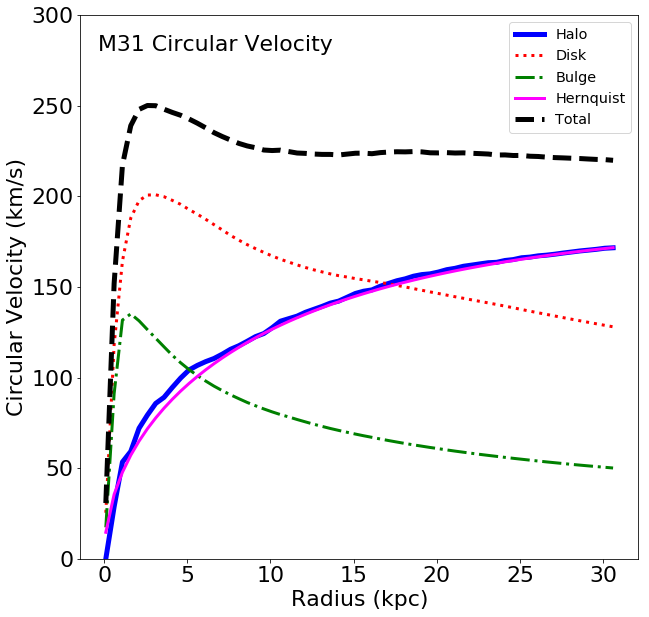

In [28]:
# Plot the Circular Velocity Profile for M31.
############################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


# Plot circular velocity for Halo 
plt.plot(R,M31.CircularVelocity(1,R), color='blue', linewidth=5, label='Halo')

# for Disk
plt.plot(R,M31.CircularVelocity(2,R), color='red', linestyle=":", linewidth=3, label='Disk')

# for Bulge
plt.plot(R,M31.CircularVelocity(3,R), color='green', linestyle="-.",linewidth=3, label='Bulge')

# Hernquist Vcirc Profile
plt.plot(R,M31.HernquistVCirc(R,ScaleM31,MtotM31), color='magenta',linewidth=3, label='Hernquist')

# TOTAL Circular Velocity
plt.plot(R,M31.CircularVelocityTotal(R), color='black', linestyle="--",linewidth=5, label='Total')



# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular Velocity (km/s)', fontsize=22)

#set axis limits
plt.ylim(0,300)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'M31 Circular Velocity', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('CircularVelocity_M31.eps', rasterized=True, dpi=350)

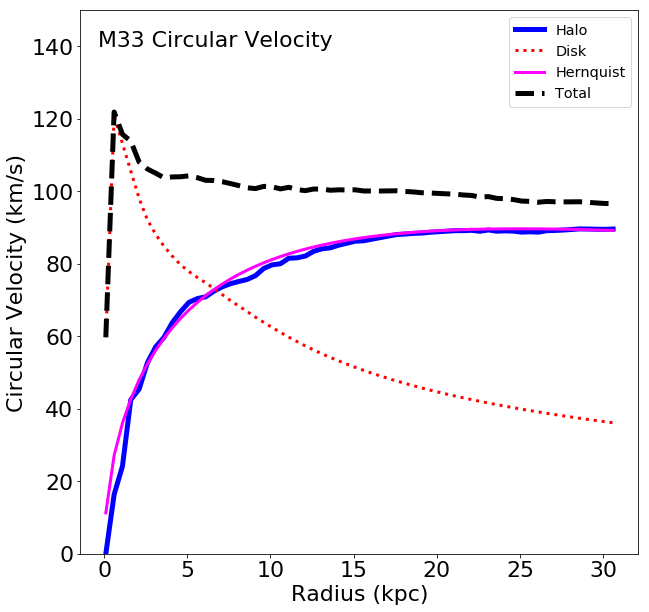

In [29]:
# In[41]:


# Plot the Circular Velocity Profile for M33.
############################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


# Plot circular velocity for Halo 
plt.plot(R,M33.CircularVelocity(1,R), color='blue', linewidth=5, label='Halo')

# for Disk
plt.plot(R,M33.CircularVelocity(2,R), color='red', linestyle=":", linewidth=3, label='Disk')

# Hernquist Vcirc Profile
plt.plot(R,M33.HernquistVCirc(R,ScaleM33,MtotM33), color='magenta',linewidth=3, label='Hernquist')

# TOTAL Circular Velocity
plt.plot(R,M33.CircularVelocityTotal(R), color='black', linestyle="--",linewidth=5, label='Total')



# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular Velocity (km/s)', fontsize=22)

#set axis limits
plt.ylim(0,150)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'M33 Circular Velocity', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('CircularVelocity_M33.eps', rasterized=True, dpi=350)